# Actividad - Proyecto práctico


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1: Marta Castillo Galán
*   Alumno 2: Unai Marín Etxebarria
*   Alumno 3: Laura Molinos Mayo
*   Alumno 4: Raúl Murillo Gallego






---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

In [ ]:
#if IN_COLAB:
  #%pip install gym==0.17.3
  #%pip install git+https://github.com/Kojoley/atari-py.git
  #%pip install keras-rl2==1.0.5
  #%pip install tensorflow==2.8
#else:
  #%pip install gym==0.17.3
  #%pip install git+https://github.com/Kojoley/atari-py.git
  #%pip install pyglet==1.5.0
  #%pip install h5py==3.1.0
  #%pip install Pillow==9.5.0
  #%pip install keras-rl2==1.0.5
  #%pip install Keras==2.2.4
  #%pip install tensorflow==2.5.3
  ##%pip install torch==2.0.1
  #%pip install agents==1.4.0

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [6]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

from tensorflow.keras.optimizers import RMSprop

#### Configuración base

In [9]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [10]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

1. Implementación de la red neuronal

In [11]:
def build_model(window_length, input_shape, nb_actions):
    model = Sequential()
    model.add(Permute((2, 3, 1), input_shape=(window_length,) + input_shape))  # (window, 84, 84) → (84, 84, window)
    model.add(Convolution2D(32, (8, 8), strides=(4, 4), activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_actions, activation='linear'))
    return model

2. Implementación de la solución DQN

In [12]:
# Preparamos memoria y política
memory = SequentialMemory(limit=100000, window_length=WINDOW_LENGTH)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr='eps',
                              value_max=1.0,
                              value_min=0.1,
                              value_test=0.05,
                              nb_steps=500000) 

# Creamos el modelo
model = build_model(WINDOW_LENGTH, INPUT_SHAPE, nb_actions)
print(model.summary())

# Creamos el procesador
processor = AtariProcessor()

#Creamos el agente
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup = 10000,
               gamma=0.99,
               target_model_update=5000,
               train_interval=1,
               delta_clip=1.0,
               )

dqn.compile(Adam(learning_rate=0.0001), metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
__________________________________________________

In [6]:
history=dqn.fit(env, nb_steps=500000, visualize=False, verbose=2)
rewards = history.history['episode_reward']

Training for 500000 steps ...


C:\Users\laura\anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    420/500000: episode: 1, duration: 8.893s, episode steps: 420, steps per second:  47, episode reward:  6.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.479 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1131/500000: episode: 2, duration: 6.674s, episode steps: 711, steps per second: 107, episode reward:  7.000, mean reward:  0.010 [ 0.000,  1.000], mean action: 2.415 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1941/500000: episode: 3, duration: 7.703s, episode steps: 810, steps per second: 105, episode reward: 10.000, mean reward:  0.012 [ 0.000,  1.000], mean action: 2.410 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   2827/500000: episode: 4, duration: 8.340s, episode steps: 886, steps per second: 106, episode reward: 11.000, mean reward:  0.012 [ 0.000,  1.000], mean action: 2.394 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   3345/500000: episode: 5, duration: 4.970s, episode steps: 518, steps per 

C:\Users\laura\anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  10540/500000: episode: 16, duration: 130.606s, episode steps: 750, steps per second:   6, episode reward:  7.000, mean reward:  0.009 [ 0.000,  1.000], mean action: 2.463 [0.000, 5.000],  loss: 0.075889, mae: 0.218802, mean_q: 0.365749, mean_eps: 0.981514
  11214/500000: episode: 17, duration: 146.513s, episode steps: 674, steps per second:   5, episode reward: 11.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.402 [0.000, 5.000],  loss: 0.006664, mae: 0.035099, mean_q: 0.064298, mean_eps: 0.980422
  11991/500000: episode: 18, duration: 167.534s, episode steps: 777, steps per second:   5, episode reward: 11.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.449 [0.000, 5.000],  loss: 0.006109, mae: 0.029985, mean_q: 0.052302, mean_eps: 0.979116
  12622/500000: episode: 19, duration: 133.224s, episode steps: 631, steps per second:   5, episode reward:  5.000, mean reward:  0.008 [ 0.000,  1.000], mean action: 2.553 [0.000, 5.000],  loss: 0.005906, mae: 0.030930, mean_

  30504/500000: episode: 48, duration: 148.514s, episode steps: 694, steps per second:   5, episode reward:  8.000, mean reward:  0.012 [ 0.000,  1.000], mean action: 2.427 [0.000, 5.000],  loss: 0.007701, mae: 0.104396, mean_q: 0.134029, mean_eps: 0.945718
  31372/500000: episode: 49, duration: 186.144s, episode steps: 868, steps per second:   5, episode reward: 15.000, mean reward:  0.017 [ 0.000,  1.000], mean action: 2.547 [0.000, 5.000],  loss: 0.008056, mae: 0.110437, mean_q: 0.139822, mean_eps: 0.944313
  31975/500000: episode: 50, duration: 130.084s, episode steps: 603, steps per second:   5, episode reward: 10.000, mean reward:  0.017 [ 0.000,  1.000], mean action: 2.617 [0.000, 5.000],  loss: 0.007539, mae: 0.112266, mean_q: 0.142244, mean_eps: 0.942989
  32515/500000: episode: 51, duration: 115.318s, episode steps: 540, steps per second:   5, episode reward:  7.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 2.459 [0.000, 5.000],  loss: 0.007113, mae: 0.109843, mean_

  52693/500000: episode: 80, duration: 104.467s, episode steps: 507, steps per second:   5, episode reward: 12.000, mean reward:  0.024 [ 0.000,  1.000], mean action: 2.606 [0.000, 5.000],  loss: 0.007651, mae: 0.175690, mean_q: 0.213711, mean_eps: 0.905610
  53342/500000: episode: 81, duration: 132.355s, episode steps: 649, steps per second:   5, episode reward: 12.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.658 [0.000, 5.000],  loss: 0.007936, mae: 0.178409, mean_q: 0.216482, mean_eps: 0.904569
  53759/500000: episode: 82, duration: 86.229s, episode steps: 417, steps per second:   5, episode reward:  9.000, mean reward:  0.022 [ 0.000,  1.000], mean action: 2.400 [0.000, 5.000],  loss: 0.007288, mae: 0.177651, mean_q: 0.216112, mean_eps: 0.903610
  54975/500000: episode: 83, duration: 250.469s, episode steps: 1216, steps per second:   5, episode reward: 17.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.569 [0.000, 5.000],  loss: 0.007359, mae: 0.177036, mean_

  73898/500000: episode: 112, duration: 89.419s, episode steps: 433, steps per second:   5, episode reward:  3.000, mean reward:  0.007 [ 0.000,  1.000], mean action: 2.656 [0.000, 5.000],  loss: 0.007984, mae: 0.234139, mean_q: 0.283352, mean_eps: 0.867374
  74691/500000: episode: 113, duration: 163.761s, episode steps: 793, steps per second:   5, episode reward: 14.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.559 [0.000, 5.000],  loss: 0.007859, mae: 0.235135, mean_q: 0.282986, mean_eps: 0.866271
  75828/500000: episode: 114, duration: 233.547s, episode steps: 1137, steps per second:   5, episode reward: 20.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.551 [0.000, 5.000],  loss: 0.008896, mae: 0.250344, mean_q: 0.302438, mean_eps: 0.864534
  76179/500000: episode: 115, duration: 73.048s, episode steps: 351, steps per second:   5, episode reward:  4.000, mean reward:  0.011 [ 0.000,  1.000], mean action: 2.664 [0.000, 5.000],  loss: 0.009191, mae: 0.256336, me

  95644/500000: episode: 144, duration: 150.073s, episode steps: 728, steps per second:   5, episode reward:  8.000, mean reward:  0.011 [ 0.000,  1.000], mean action: 2.802 [0.000, 5.000],  loss: 0.008398, mae: 0.304945, mean_q: 0.366715, mean_eps: 0.828497
  96554/500000: episode: 145, duration: 187.872s, episode steps: 910, steps per second:   5, episode reward: 15.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.802 [0.000, 5.000],  loss: 0.008707, mae: 0.309079, mean_q: 0.371222, mean_eps: 0.827023
  97694/500000: episode: 146, duration: 238.101s, episode steps: 1140, steps per second:   5, episode reward: 16.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.513 [0.000, 5.000],  loss: 0.008353, mae: 0.309955, mean_q: 0.372243, mean_eps: 0.825178
  98457/500000: episode: 147, duration: 158.798s, episode steps: 763, steps per second:   5, episode reward: 11.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.545 [0.000, 5.000],  loss: 0.008735, mae: 0.315587, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


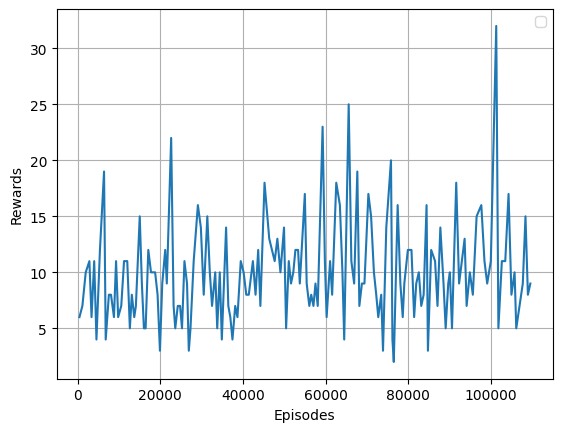

In [2]:
# Obtener las métricas
rewards = history.history['episode_reward']
steps = history.history['nb_steps']

# Crear el gráfico
plt.plot(steps, rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#Evaluación en modo test
scores = dqn.test(env, nb_episodes=20, visualize=False)
print("Media de recompensa:", np.mean(scores.history['episode_reward']))

Testing for 20 episodes ...


C:\Users\laura\anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 1: reward: 3.000, steps: 935
Episode 2: reward: 1.000, steps: 683
Episode 3: reward: 1.000, steps: 679
Episode 4: reward: 1.000, steps: 679
Episode 5: reward: 1.000, steps: 672
Episode 6: reward: 2.000, steps: 925
Episode 7: reward: 4.000, steps: 934
Episode 8: reward: 1.000, steps: 690
Episode 9: reward: 2.000, steps: 960
Episode 10: reward: 1.000, steps: 688
Episode 11: reward: 3.000, steps: 924
Episode 12: reward: 3.000, steps: 922
Episode 13: reward: 1.000, steps: 691
Episode 14: reward: 4.000, steps: 727
Episode 15: reward: 4.000, steps: 919
Episode 16: reward: 1.000, steps: 686
Episode 17: reward: 1.000, steps: 684
Episode 18: reward: 3.000, steps: 932
Episode 19: reward: 3.000, steps: 929
Episode 20: reward: 4.000, steps: 925
Media de recompensa: 2.2


In [16]:
#Guardado de pesos
dqn.save_weights('dqn_spaceinvaders_weights.h5f', overwrite=True)

3. Justificación de los parámetros seleccionados y de los resultados obtenidos

---